## Fine-tune PaliGemma with JAX

<table class="tfo-notebook-buttons" align="left">
<td>
<a target="_blank" href="https://ai.google.dev/gemma/docs/paligemma/fine-tuning-paligemma"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
</td>
<td>
<a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/fine-tuning-paligemma.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>
<td>
<a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/paligemma/fine-tuning-paligemma.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td>
</table>


## Requirements

To run this notebook, you will need to install the following dependencies:

`Python==3.11`

```bash
pip install python-dotenv kagglehub transformers gdown jax[cuda12] pillow ipykernel ipywidgets tensorflow ml-dtypes flax tqdm orbax-checkpoint matplotlib scikit-learn -U
```

Also, move `data/food-ingredients-101`, `data/food-101` & `data/ingredients-101` to root dir.

If `data/food-ingredients-101` is not present, create it using `merging_food101_ingredients101.ipynb`

### Set environment variables

Set the environment variables for `KAGGLE_USERNAME` and `KAGGLE_KEY`.

In [ ]:
import os

print(os.getenv('KAGGLE_USERNAME'))

In [2]:
# set cuda to only recognize gpu 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
# Note: `userdata.get` is a Colab API. If you're not using Colab, set the env
# vars as appropriate or make your credentials available in ~/.kaggle/kaggle.json

# for running on colab
# from google.colab import userdata
# os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
# os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

# for running on local
from dotenv import load_dotenv
load_dotenv()
os.environ["KAGGLE_USERNAME"] = os.getenv('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = os.getenv('KAGGLE_KEY')

print(os.getenv('KAGGLE_USERNAME'))

In [4]:
# for linux
!export KAGGLE_USERNAME
!export KAGGLE_KEY

### Fetch the `big_vision` repository and install related dependencies

Download the `big_vision` repository to your Colab notebook from GitHub and install dependencies related to `big_vision` by running the following code.

In [5]:
import os
import sys

# TPUs with
if "COLAB_TPU_ADDR" in os.environ:
  raise "It seems you are using Colab with remote TPUs which is not supported."

# Fetch big_vision repository if python doesn't know about it and install
# dependencies needed for this notebook.
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

# Append big_vision code to python import path
if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

# Install missing dependencies. Assume jax~=0.4.25 with GPU available.
!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"


### Import JAX and other dependencies

Import JAX and other dependencies required for PaliGemma, like TensorFlow and NumPy.

In [6]:
import base64
import functools
import html
import io
import os
import warnings

import jax
import jax.numpy as jnp
import numpy as np
import ml_collections

import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# Import model definition from big_vision
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

# Import big vision utilities
import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

# === Additional imports ===
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import accuracy_score, precision_score, recall_score
from rouge_score import rouge_scorer
from tqdm import tqdm

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

2024-06-29 01:20:55.133581: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_5585/3370877366.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


JAX version:  0.4.29
JAX platform: gpu
JAX devices:  1


2024-06-29 01:20:56.539553: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Download and configure the model

In this step, you'll download the model checkpoint and configure it so that you can fine-tune it later on. This step shows you how to move model parameters into TPU memory, which is useful for fine-tuning models on devices with limited resources.

### Download the model checkpoint

PaliGemma includes several model variations. For this tutorial, you'll use the base [JAX/FLAX PaliGemma 3B weight model](https://www.kaggle.com/models/google/paligemma/jax/paligemma-3b-pt-224).

Download the `float16` version of the model checkpoint from Kaggle by running the following code. This process takes several minutes to complete.

In [7]:
import os
import kagglehub

# from google.colab import auth
# auth.authenticate_user()

In [8]:
MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  # Note: kaggle archive contains the same checkpoint in multiple formats.
  # Download only the float16 model.
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')
  print(f"Model path: {MODEL_PATH}")

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

Model path: /home/simon/.cache/kagglehub/models/google/paligemma/jax/paligemma-3b-pt-224/1/paligemma-3b-pt-224.f16.npz


In [9]:
DATA_DIR_old="./longcap100"
if not os.path.exists(DATA_DIR_old):
  print("Downloading the dataset...")
  !gsutil -m -q cp -n -r gs://longcap100/ .
  print(f"Data path: {DATA_DIR_old}")

FOOD_DATA_DIR="./food-101"
if not os.path.exists(FOOD_DATA_DIR):
  print("Downloading the dataset...")
  !kaggle datasets download -d kmader/food41
  !unzip -q food41.zip -d ./food-101
  print(f"Data path: {FOOD_DATA_DIR}")

import os
import gdown

INGREDIENTS_DATA_DIR = "./ingredients-101"
if not os.path.exists(INGREDIENTS_DATA_DIR):
    os.makedirs(INGREDIENTS_DATA_DIR)  # Ensure the target directory exists
    print("Downloading the dataset...")
    # Define the URL of the Google Drive file
    url = 'https://drive.google.com/uc?id=14ztu2gjdowZdMdCvo1tAZJ0aK5rMs4kb'
    # Define the output file path
    output = 'Ingredients101.zip'
    # Download the file
    gdown.download(url, output, quiet=False)
    # Unzip only the contents of the "Ingredients101" directory directly into the target directory
    os.system(f'unzip -q {output} "Ingredients101/*" -d {INGREDIENTS_DATA_DIR}')
    # Move contents up from the nested "Ingredients101" directory and remove it
    nested_dir = os.path.join(INGREDIENTS_DATA_DIR, 'Ingredients101')
    for filename in os.listdir(nested_dir):
        os.rename(os.path.join(nested_dir, filename), os.path.join(INGREDIENTS_DATA_DIR, filename))
    os.rmdir(nested_dir)
    # Clean up the zip file after extraction
    os.remove(output)
    print(f"Data path: {INGREDIENTS_DATA_DIR}")

### Configure the model

It's time to actually start configuring the model that you're going to use.

For this notebook, you need to be able to fit your model onto a T4 GPU. Having a limited resource like space constraints means that you have to be mindful of how your model is configured.

If you fine-tune every parameter, your model won't be able to run in the notebook environment. As a result, in this part of the notebook, you'll configure your model so that it has the ability to freeze some of the parameters, and only fine-tune the parameters that really need to be fine-tuned for the model to give you accurate results. In LLMs, parameters are said to be *frozen* when they are no longer actively being used to train the model.

In order to configure your model, you need to:

* Initialize the `model_config` as a [`FrozenConfigDict`](https://github.com/google/ml_collections/tree/master#frozenconfigdict) so that you can freeze some of the parameters and keep memory usage low
* Initialize an instance of the PaliGemma `Model` class using the `model_config` as its configurations
* Load the model parameters into RAM
* Define a `decode` function to sample outputs from the model

This code in this cell takes about a minute to run to completion.

In [10]:
# Define model
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params - this can take up to 1 minute in T4 colabs.
params = paligemma.load(None, MODEL_PATH, model_config)

# Define `decode` function to sample outputs from the model.
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

### Move model parameters into GPU/TPU memory

Now you need to move the model parameters into GPU/TPU memory. First, shard the parameters across the available GPUs, then load the parameters. Here, you'll load the parameters sequentially. This process takes longer than loading them simultaneously, but it requires more RAM than you have available in this notebook.

Finally, print out all of the parameters to see what type each individual parameter is cast to. Frozen parameters are kept as `float16`, while the trainable parameters are cast to `float32`. When you inspect the list, you'll see that most of the parameters have been frozen and are `float16`.

In [11]:
# Create a pytree mask of the trainable params.
def is_trainable_param(name, param):  # pylint: disable=unused-argument
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

# If more than one device is available (e.g. multiple GPUs) the parameters can
# be sharded across them to reduce HBM usage per device.
mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

# Yes: Some donated buffers are not usable.
warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

# Loading all params in simultaneous - albeit much faster and more succinct -
# requires more RAM than the T4 colab runtimes have by default.
# Instead we do it param by param.
params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

# Print params to show what the model is made of.
def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

# print(" == Model params == ")
# parameter_overview(params)

2024-06-29 01:21:06.703452: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Prepare to tune the model

Now that your model is configured, you can tune it. In this step, you'll create your model's inputs as well as the training and validation iterators, view the training examples, and define the training and validation loops.

### Create model inputs

The model checkpoint you're using has already been trained on images of various aspect ratios that have been resized to 224x224 pixels, and to handle tokenized texts.

The code below defines three functions that you'll use in the next step create the model's inputs:

* **`preprocess_image`:** Normalizes the image data. In this case, pre-processing converts the passed-in image to greyscale, removes the alpha layer, and resizes the passed-in image to the size required by the model for image inputs (224x224 pixels).
* **`preprocess_tokens`:** Splits the tokens up and adds flags to mark whether a token is a prefix or suffix token. These flags will be used later on in the code, during the training step and the evaluation loop.
* **`postprocess_tokens`:** Removes any tokens left at and/or after the end-of-sequence (EOS) token and returns the remaining decoded tokens.


In [12]:
def preprocess_image(image, size=224):
  # Model has been trained to handle images of different aspects ratios
  # resized to 224x224 in the range [-1, 1]. Bilinear and antialias resize
  # options are helpful to improve quality in some tasks.
  image = np.asarray(image)
  if image.ndim == 2:  # Convert image without last channel into greyscale.
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]  # Remove alpha layer.
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0  # [0, 255]->[-1,1]

def preprocess_tokens(prefix, suffix=None, seqlen=None):
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
    mask_ar = [0] * len(tokens)
    mask_loss = [0] * len(tokens)

    if suffix:
        suffix_tokens = tokenizer.encode(suffix, add_eos=True)
        tokens += suffix_tokens
        mask_ar += [1] * len(suffix_tokens)
        mask_loss += [1] * len(suffix_tokens)

    mask_input = [1] * len(tokens)
    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()  # np.array to list[int]
  try:  # Remove tokens at and after EOS if any.
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)


### Create the training and validation iterators

Create two iterators:

*   A **training iterator** to allow the training process to go through the data in chunks rather than processing it all at once
    *   This allows you to do some data pre-processing before use
*   A **validation iterator** that allows the training process to iterate over the validation dataset to see how well the tuned model aligned with the provided results

In [13]:
# HERE

In [14]:
DATA_DIR = './food-ingredients-101'

In [15]:
import os
import json

def merge_data(food_data_dir, ingredients_data_dir, data_dir):
    # Create the data directory if it doesn't exist
    os.makedirs(data_dir, exist_ok=True)

    # Define the paths to the required files
    food_train_file = os.path.join(food_data_dir, 'meta', 'train.json')
    food_test_file = os.path.join(food_data_dir, 'meta', 'test.json')
    ingredients_train_images = os.path.join(ingredients_data_dir, 'Annotations', 'train_images.txt')
    ingredients_train_labels = os.path.join(ingredients_data_dir, 'Annotations', 'train_labels.txt')
    ingredients_test_images = os.path.join(ingredients_data_dir, 'Annotations', 'test_images.txt')
    ingredients_test_labels = os.path.join(ingredients_data_dir, 'Annotations', 'test_labels.txt')
    ingredients_file = os.path.join(ingredients_data_dir, 'Annotations', 'ingredients.txt')

    # Load the ingredients data
    with open(ingredients_file, 'r') as f:
        ingredients_list = [line.strip() for line in f.readlines()]

    # Create a dictionary to map each class to its ingredients
    class_to_ingredients = {i: ingredients for i, ingredients in enumerate(ingredients_list)}

    def create_jsonl(image_file, label_file, split):
        with open(image_file, 'r') as f:
            image_paths = [line.strip() for line in f.readlines()]

        with open(label_file, 'r') as f:
            labels = [int(line.strip()) for line in f.readlines()]

        if len(image_paths) != len(labels):
            raise ValueError("The number of images and labels do not match.")

        output_file = os.path.join(data_dir, f'{split}.jsonl')
        with open(output_file, 'w') as f_out:
            for image_path, label in zip(image_paths, labels):
                ingredients = class_to_ingredients[label]
                suffix = ', '.join(ingredients.split(','))
                record = {
                    "prefix": "",
                    "suffix": suffix,
                    "image": food_data_dir + '/images/' + image_path + '.jpg',
                }
                f_out.write(json.dumps(record) + '\n')

    # Process the train and test splits
    create_jsonl(ingredients_train_images, ingredients_train_labels, 'train')
    create_jsonl(ingredients_test_images, ingredients_test_labels, 'test')

# Example usage
merge_data('food-101', 'ingredients-101', 'food-ingredients-101')

In [16]:
SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "train.jsonl"),
    # fopen_keys={"image": FOOD_DATA_DIR}
    )

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "test.jsonl"),
    # fopen_keys={"image": FOOD_DATA_DIR}
    )


from PIL import Image
import os
import io

def train_data_iterator():
    """Never ending iterator over training examples."""
    dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
    for example in dataset.as_numpy_iterator():
        try:
            # Decode the byte path to a string and form the full image path
            image_path = example["image"].decode()
            image = Image.open(image_path)
            image = preprocess_image(image)
        except Exception as e:
            # print(f"Error opening image at {image_path}: {e}")
            continue

        prefix = "caption en"
        suffix = example["suffix"].decode().lower()
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "mask_ar": np.asarray(mask_ar),
            "mask_loss": np.asarray(mask_loss),
            # "image_path": image_path,
        }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    try:
        # Decode the byte path to a string and form the full image path
        image_path = example["image"].decode()
        image = Image.open(image_path)
        image = preprocess_image(image)
    except Exception as e:
        # print(f"Error opening image at {image_path}: {e}")
        continue

    prefix = "caption en"  # Could also be a different prefix per example.
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


### View training examples

In this notebook, the training data contains 90 images that are paired with long descriptions of what's depicted in the image.

**Note:** Normal training data sets that are meant to be used for practical use cases should contain more images, but this notebook limits the number of data points so that you can train the model in a reasonable amount of time for an example.

The code below prints a random selection of images with their descriptions from the training data set so that you can see what the images and descriptions your model is trained on looks like. Each image is displayed in as a 128x128 pixel JPEG, with the description printed next to the image to the right.

Training examples



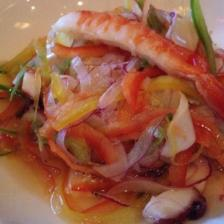
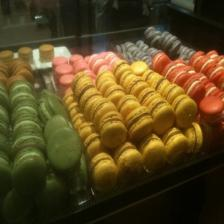
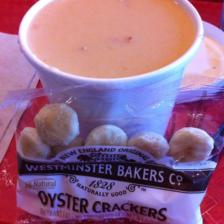
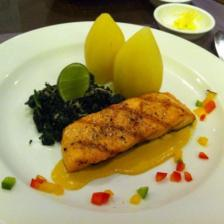
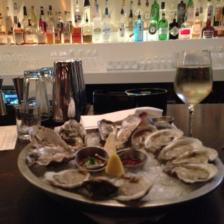
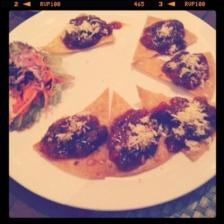
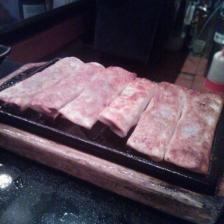
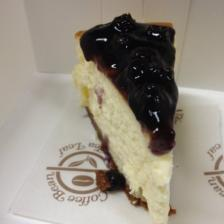

In [17]:
def render_inline(image, resize=(128, 128)):
  """Convert image into inline html."""
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)  # [-1,1] -> [0, 255]
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
  caption = postprocess_tokens(example["text"])  # detokenize model input.
  caption = caption[len("caption en\n"):]        # strip prefix
  html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

### Define the training and evaluation loops

Define the training loop to train the model on the provided dataset, and the evaluation loop to look at all of the examples in the validation dataset and make its predictions.

#### Defining the training loop

The `update_fn` function defines the training step. During the training step, the loss per example is calculated and stochastic gradient descent (SGD) is applied to the trainable parameters.

Recall that earlier in the notebook, you included flags in the `preprocess_tokens` function that included `mask_loss`. You'll use the `mask_loss` flag here to exclude prefix and padded tokens from the loss. Without it, the loss calculation will be skewed. You also need to normalize each example, since each of them has a different number of tokens. After the prefix and padded tokens have been excluded and the examples have been normalized, you can calculate the loss per example.

The training step also includes a function to apply an SGD to optimize the training.

#### Defining the evaluation loop

The `make_predictions` function is your evaluation loop. The evaluation loop is fairly straight forward with one notable change. If you recall from the beginning of the notebook, you only have 90 examples in your training data set. This is a very small amount of training examples, and your model ends up not having enough examples for the batch size when you run the training. This means that in the evaluation loop, you need to pad the batch by repeating examples.

To make sure that your evaluation loop only counts actual examples and not the padded examples, you have to apply a mask to the padded examples that excludes them from the output.

In [18]:
# The main update_fn using a simple stochastic gradient descent (SGD).
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    # The model takes as input txts[:, :-1] but the loss is defined as predicting
    # next tokens txts[:, 1:]. Additionally, mask_loss[:, 1:] indicates which tokens
    # are part of the loss (e.g. prefix and padded tokens are not included).
    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    # Compute the loss per example. i.e. the mean of per token pplx.
    # Since each example has a different number of tokens we normalize it.
    token_pplx = jnp.sum(logp * targets, axis=-1)  # sum across vocab_size.
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1)  # sum across seq_len.
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)  # weight by num of tokens.

    # batch_loss: mean of per example loss.
    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  # Apply gradients to trainable params using SGD.
  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

# Evaluation/inference loop.
def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    # Construct a list of examples in the batch.
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)  # Indicates true example.
    except StopIteration:
      if len(examples) == 0:
        return outputs

    # Not enough examples to complete a batch. Pad by repeating last example.
    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)  # Indicates padding example.

    # Convert list of examples into a dict of np.arrays and load onto devices.
    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    # Make model predictions
    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    # Fetch model predictions to device and detokenize.
    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask]  # remove padding examples.
    responses = [postprocess_tokens(t) for t in tokens]

    # Append to html output.
    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

## Tune the model

Now that you've set everything up and taken a look at the training data, it's time to finally tune the model. The code below runs the training loop for the model for 64 steps and prints the learning rate (`lr` in the printed output) and loss rate for each step.

Every 16 steps, the model prints what its predictions are at that step in the training. This code prints out predictions for the same set of images so that you can see the model's ability to predict descriptions improve over time.

At earlier steps in the training, there's likely issues with the descriptions, such as repeated sentences as the model gets stuck in its predictive loop or unfinished sentences. The model's predictions become steadily more accurate as training progresses. By step 64, the model's predictions should closely resemble the descriptions provided by the training data.

This process takes around 15 minutes to complete on T4 TPUs.

In [19]:
# checkpointing setup

ckpt_dir = './checkpoints'

# ==== With Orbax ====
from flax.training import orbax_utils
import orbax.checkpoint

# Initialize the PyTree Checkpointer
pytree_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

# Define checkpoint manager options
options = orbax.checkpoint.CheckpointManagerOptions(
    max_to_keep=4,  # Keep only the newest 3 checkpoints
    create=True
)

# Create the checkpoint manager
checkpoint_manager = orbax.checkpoint.CheckpointManager(
    ckpt_dir, pytree_checkpointer, options
)

In [20]:
def batch_val_score_iterator(batch_size=4, ordered=False):
    examples = []
    for example in val_dataset.get_tfdata(ordered=ordered).as_numpy_iterator():
        try:
            image_path = example["image"].decode()
            image = Image.open(image_path)
            image = preprocess_image(image)
            
            prefix = "caption en"
            suffix = example["suffix"].decode().lower()
            tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
            
            examples.append({
                "image": np.asarray(image),
                "text": np.asarray(tokens),
                "mask_ar": np.asarray(mask_ar),
                "mask_input": np.asarray(mask_input),
                "suffix": suffix,
            })
            
            if len(examples) == batch_size:
                yield examples
                examples = []
        except Exception as e:
            print(f"Error processing image: {e}")
            continue
    
    if examples:  # Yield any remaining examples
        yield examples

def compute_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return (scores['rouge1'].fmeasure + scores['rouge2'].fmeasure + scores['rougeL'].fmeasure) / 3

def ingredient_overlap_f1_score(reference, candidate):
    ref_ingredients = set(reference.lower().split(', '))
    cand_ingredients = set(candidate.lower().split(', '))
    overlap = ref_ingredients.intersection(cand_ingredients)
    precision = len(overlap) / len(cand_ingredients) if cand_ingredients else 0
    recall = len(overlap) / len(ref_ingredients) if ref_ingredients else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

from sklearn.metrics import accuracy_score, precision_score, recall_score

def evaluate_model_batch(params, batch_size=4, num_examples=None, ordered=False):
    bleu_scores = []
    rouge_scores = []
    ingredient_overlap_scores = []
    examples = []
    all_ground_truths = []
    all_predictions = []
    
    smoother = SmoothingFunction().method1
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    total_processed = 0
    num_examples = num_examples or val_dataset.total_examples // batch_size
    pbar = tqdm(total=num_examples)
    
    for batch in batch_val_score_iterator(batch_size=batch_size, ordered=ordered):
        batch_images = np.stack([ex['image'] for ex in batch])
        batch_tokens = np.stack([ex['text'] for ex in batch])
        batch_mask_ar = np.stack([ex['mask_ar'] for ex in batch])
        batch_mask_input = np.stack([ex['mask_input'] for ex in batch])
        ground_truths = [ex['suffix'] for ex in batch]
        
        # Generate captions
        batch_input = {
            "image": batch_images,
            "text": batch_tokens,
            "mask_ar": batch_mask_ar,
            "mask_input": batch_mask_input,
            "_mask": np.ones(len(batch), dtype=bool)
        }
        generated_tokens = decode({"params": params}, 
                                  batch=batch_input, 
                                  max_decode_len=SEQLEN, 
                                  sampler="greedy")
        
        generated_captions = [postprocess_tokens(tokens) for tokens in generated_tokens]
        
        batch_bleu = []
        batch_rouge = []
        batch_ingredient_overlap = []
        
        for ground_truth, generated_caption in zip(ground_truths, generated_captions):
            # Compute BLEU
            bleu = sentence_bleu([ground_truth.split()], generated_caption.split(), 
                                 smoothing_function=smoother, weights=(0.25, 0.25, 0.25, 0.25))
            batch_bleu.append(bleu)
            
            # Compute ROUGE
            rouge = compute_rouge(ground_truth, generated_caption)
            batch_rouge.append(rouge)
            
            # Compute ingredient overlap score
            ingredient_overlap = ingredient_overlap_f1_score(ground_truth, generated_caption)
            batch_ingredient_overlap.append(ingredient_overlap)
            
            # Store example
            examples.append((ground_truth, generated_caption))
        
        bleu_scores.extend(batch_bleu)
        rouge_scores.extend(batch_rouge)
        ingredient_overlap_scores.extend(batch_ingredient_overlap)
        all_ground_truths.extend(ground_truths)
        all_predictions.extend(generated_captions)
        
        total_processed += len(batch)
        
        # Calculate dynamic accuracy, precision, and recall
        if all_ground_truths and all_predictions:
            accuracy = accuracy_score(all_ground_truths, all_predictions)
            precision = precision_score(all_ground_truths, all_predictions, average='weighted', zero_division=0)
            recall = recall_score(all_ground_truths, all_predictions, average='weighted', zero_division=0)
        else:
            accuracy, precision, recall = 0, 0, 0
        
        # Update progress bar with current average scores and new metrics
        avg_bleu = np.mean(bleu_scores)
        avg_rouge = np.mean(rouge_scores)
        avg_f1 = np.mean(ingredient_overlap_scores)
        
        pbar.set_description(f"BLEU: {avg_bleu:.3f} - ROUGE: {avg_rouge:.3f} - F1: {avg_f1:.3f} - "
                             f"ACC: {accuracy:.3f} - PREC: {precision:.3f} - REC: {recall:.3f}")
        pbar.update(len(batch))
        
        if num_examples and total_processed >= num_examples:
            break
    
    pbar.close()
    
    # Final calculation for accuracy, precision, and recall
    final_accuracy = accuracy_score(all_ground_truths, all_predictions)
    final_precision = precision_score(all_ground_truths, all_predictions, average='weighted', zero_division=0)
    final_recall = recall_score(all_ground_truths, all_predictions, average='weighted', zero_division=0)
    
    return {
        "bleu": np.mean(bleu_scores),
        "rouge": np.mean(rouge_scores),
        "ingredient_overlap": np.mean(ingredient_overlap_scores),
        "accuracy": final_accuracy,
        "precision": final_precision,
        "recall": final_recall,
        "examples": examples[:num_examples] if num_examples else examples,
        "predictions": all_predictions,
        "ground_truths": all_ground_truths
    }

In [21]:
# BATCH_SIZE = 8
# LEARNING_RATE = 0.002
# EPOCHS = 1
# MAX_EXAMPLES = -1  # -1 to use all training data
# EVAL_STEPS = 200  # Evaluate every n steps
# VALIDATION_BATCH_SIZE = 4
# VALIDATION_EXAMPLES = 100
# tolerance = 0.01  # Tolerance for score variation to save a checkpoint

# def count_dataset_entries(jsonl_file_path):
#     with open(jsonl_file_path, 'r') as file:
#         return sum(1 for _ in file)

# train_entries = count_dataset_entries('food-ingredients-101/train.jsonl')

# if MAX_EXAMPLES != -1:
#     train_entries = min(train_entries, MAX_EXAMPLES)
# print("Number of training examples:", train_entries)

# TRAIN_STEPS = train_entries // BATCH_SIZE

# train_data_it = train_data_iterator()

# sched_fn = big_vision.utils.create_learning_rate_schedule(
#     total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
#     decay_type="cosine", warmup_percent=0.10)

# pbar = tqdm(total=TRAIN_STEPS, dynamic_ncols=True)

# loss_values = []
# best_score = 0

# # Logging setup
# import wandb

# wandb.init(project="paligemma-jax-local", config={
#     "model": "paligemma-3b-pt-224",
#     "batch_size": BATCH_SIZE,
#     "learning_rate": LEARNING_RATE,
#     "train_steps": TRAIN_STEPS,
#     "seq_len": SEQLEN,
#     "ckpt_dir": ckpt_dir,
#     "tolerance": tolerance,
#     "decay_type": "cosine",
#     "warmup_percent": 0.10,
#     "epochs": EPOCHS,
# })

# for step in range(1, TRAIN_STEPS+1):
#     # Make list of N training examples.
#     examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

#     # Convert list of examples into a dict of np.arrays and load onto devices.
#     batch = jax.tree.map(lambda *x: np.stack(x), *examples)
#     batch = big_vision.utils.reshard(batch, data_sharding)

#     # Training step and report training loss
#     learning_rate = sched_fn(step)
#     params, loss = update_fn(params, batch, learning_rate)

#     loss = jax.device_get(loss)
#     loss_values.append(loss)

#     # Log loss to wandb
#     wandb.log({"train_loss": loss, "learning_rate": learning_rate})

#     pbar.set_postfix({'lr': f'{learning_rate:.5f}', 'loss': f'{loss:.4f}'}, refresh=True)
#     pbar.update()

#     if (step % EVAL_STEPS) == 0:
#         print(f"\nEvaluating at step {step}")
        
#         # Calculate validation scores
#         val_results = evaluate_model_batch(
#             params, 
#             batch_size=VALIDATION_BATCH_SIZE, 
#             num_examples=VALIDATION_EXAMPLES,
#             ordered=False
#         )
        
#         # Log validation scores to wandb
#         wandb.log({
#             "val_bleu": val_results['bleu'],
#             "val_rouge": val_results['rouge'],
#             "val_f1": val_results['ingredient_overlap'],
#             "val_accuracy": val_results['accuracy'],
#             "val_precision": val_results['precision'],
#             "val_recall": val_results['recall']
#         })
        
#         print(f"Validation Results:")
#         print(f"BLEU Score: {val_results['bleu']:.4f}")
#         print(f"ROUGE Score: {val_results['rouge']:.4f}")
#         print(f"F1-Score: {val_results['ingredient_overlap']:.4f}")
#         print(f"Accuracy: {val_results['accuracy']:.4f}")
#         print(f"Precision: {val_results['precision']:.4f}")
#         print(f"Recall: {val_results['recall']:.4f}")

#         # Print a few examples
#         print("\nExamples:")
#         for i, (ground_truth, generated_caption) in enumerate(val_results['examples'][:3]):
#             print(f"\nExample {i+1}:")
#             print(f"Ground Truth: {ground_truth}")
#             print(f"Generated: {generated_caption}")

#         # Visual inspection of predictions (using the first validation iterator)
#         # print("\nVisual inspection of predictions:")
#         # html_out = ""
#         # for image, caption in make_predictions(
#         #     validation_data_iterator(), num_examples=4, batch_size=4):
#         #     html_out += render_example(image, caption)
#         # display(HTML(html_out))

#         # Save checkpoint if the validation score improves
#         current_score = val_results['bleu'] + val_results['rouge'] + val_results['ingredient_overlap']
#         if current_score >= best_score + tolerance:
#             print(f"Saving checkpoint at step {step}")
#             ckpt = {"params": params}
#             save_args = orbax_utils.save_args_from_target(ckpt)
#             checkpoint_manager.save(
#                 step, 
#                 ckpt, 
#                 save_kwargs={'save_args': save_args}
#             )
#             best_score = current_score

# pbar.close()

## Output

The validation data for this notebook consists of just 10 images. In normal code, you would likely have many more data points for validation, but for this notebook, run the following code to generate descriptions for all 10 images. After tuning the model, these descriptions should be very similar in form and content coverage to the descriptions included with the training data that you looked at earlier in this notebook.

Run the below code to generate descriptions for the validation data set.

In [ ]:
MAX_VALIDATION_EXAMPLES = 8

print("Model predictions")
html_out = ""
for image, caption in make_predictions(
    validation_data_iterator(), num_examples=MAX_VALIDATION_EXAMPLES, batch_size=8):
  html_out += render_example(image, caption)
display(HTML(html_out))


In [ ]:
# # save the final checkpoint

# ckpt = {"params": params}
# save_args = orbax_utils.save_args_from_target(ckpt)
# checkpoint_manager.save(
#     step, 
#     ckpt, 
#     save_kwargs={'save_args': save_args}
#     )

## Validation

In [22]:
# Load latest checkpoint
best_step = checkpoint_manager.best_step()
# best_step = 200
best_ckpt = checkpoint_manager.restore(best_step)
params = best_ckpt['params']

In [23]:
best_step

8000

In [24]:
# Evaluate the model
results = evaluate_model_batch(
    params, 
    batch_size=8,  # 8
    # num_examples=4,
    ordered=False
)
print(f"\nValidation Results:")
print(f"\tBLEU: {results['bleu']:.4f}")
print(f"\tROUGE: {results['rouge']:.4f}")
print(f"\tF1: {results['ingredient_overlap']:.4f}")
print(f"\tAccuracy: {results['accuracy']:.4f}") 
print(f"\tPrecision: {results['precision']:.4f}")
print(f"\tRecall: {results['recall']:.4f}")

# Print a few examples
print("\nExamples:")
for i, (ground_truth, generated_caption) in enumerate(results['examples'][:5]):
    print(f"\nExample {i+1}:")
    print(f"Ground Truth: {ground_truth}")
    print(f"Generated: {generated_caption}")

BLEU: 0.922 - ROUGE: 0.932 - F1: 0.929 - ACC: 0.921 - PREC: 0.927 - REC: 0.921: : 3160it [6:39:22,  7.58s/it]                          


Validation Results:
	BLEU: 0.9218
	ROUGE: 0.9316
	F1: 0.9286
	Accuracy: 0.9206
	Precision: 0.9267
	Recall: 0.9206

Examples:

Example 1:
Ground Truth: boneless skinless chicken breasts, ground black pepper, salt, curry powder, vegetable oil, yellow onion, garlic cloves, fresh ginger, low sodium chicken broth, corn starch, sugar, frozen peas, greek yogurt, chopped fresh cilantro
Generated: boneless skinless chicken breasts, ground black pepper, salt, curry powder, vegetable oil, yellow onion, garlic cloves, fresh ginger, low sodium chicken broth, corn starch, sugar, frozen peas, greek yogurt, chopped fresh cilantro

Example 2:
Ground Truth: sea scallops, cajun seasoning, olive oil, butter, ground cayenne pepper, salt, pepper, greens
Generated: cheese ravioli, pasta sauce, mozzarella cheese, grated parmesan cheese

Example 3:
Ground Truth: strawberries, sugar, heavy whipping cream, vanilla, honey, biscuits
Generated: strawberries, sugar, heavy whipping cream, vanilla, honey, biscuits

E

>>> BLEU: 0.922 - ROUGE: 0.932 - F1: 0.929 - ACC: 0.921 - PREC: 0.927 - REC: 0.921: : 3160it [6:39:22,  7.58s/it]   
                       
Validation Results:

	BLEU: 0.9218
	ROUGE: 0.9316
	F1: 0.9286
	Accuracy: 0.9206
	Precision: 0.9267
	Recall: 0.9206

Examples:

Example 1:
Ground Truth: boneless skinless chicken breasts, ground black pepper, salt, curry powder, vegetable oil, yellow onion, garlic cloves, fresh ginger, low sodium chicken broth, corn starch, sugar, frozen peas, greek yogurt, chopped fresh cilantro
Generated: boneless skinless chicken breasts, ground black pepper, salt, curry powder, vegetable oil, yellow onion, garlic cloves, fresh ginger, low sodium chicken broth, corn starch, sugar, frozen peas, greek yogurt, chopped fresh cilantro

Example 2:
Ground Truth: sea scallops, cajun seasoning, olive oil, butter, ground cayenne pepper, salt, pepper, greens
Generated: cheese ravioli, pasta sauce, mozzarella cheese, grated parmesan cheese

Example 3:
Ground Truth: strawberries, sugar, heavy whipping cream, vanilla, honey, biscuits
Generated: strawberries, sugar, heavy whipping cream, vanilla, honey, biscuits

Example 4:
Ground Truth: cheese ravioli, pasta sauce, mozzarella cheese, grated parmesan cheese
Generated: cheese ravioli, pasta sauce, mozzarella cheese, grated parmesan cheese

Example 5:
Ground Truth: whipping cream, dark chocolate, powdered sugar, unsalted butter
Generated: whipping cream, dark chocolate, powdered sugar, unsalted butter

